In [1]:
! pip install googlesearch-python -q

In [2]:
import sys

sys.path.append("..")
from typing import List

import requests
from bs4 import BeautifulSoup
from googlesearch import search
from pydantic import BaseModel, Field

from brain.sdk import BrainClient

In [3]:
brain_client = BrainClient("http://127.0.0.1:8000")

In [4]:
SEARCH_RESULTS_LIMIT = 5  # Number of search results to fetch
SCRAPE_TIMEOUT = 5        # Timeout for each article scrape request

# %%
# Reasoner 1: Keyword Extractor
class ExtractedKeywords(BaseModel):
    keywords: List[str] = Field(..., description="List of keywords extracted from the tweet.")
0
@brain_client.reasoner(schema=ExtractedKeywords)
def keyword_extractor(tweet: str):
    # Mock keyword extraction by splitting the tweet into words
    keywords = [word for word in tweet.split() if len(word) > 3]
    return (
        f"Extract keywords from tweet: {keywords}",
        "Analyze the tweet and extract relevant keywords for article generation."
    )
keyword_extractor_id = keyword_extractor.register()

In [5]:
# Reasoner 2: Query Generator
class SearchQuery(BaseModel):
    query: str = Field(..., description="The generated search query.")

@brain_client.reasoner(schema=SearchQuery)
def query_generator(keywords: List[str], person: str):
    # Generate a search query based on keywords and person's name
    query = f"{person} {' '.join(keywords)}"
    return (
        f"Generated search query: {query}",
        f"Generate a search query using the keywords {keywords} and the name {person}."
    )
query_generator_id = query_generator.register()


In [6]:
# Reasoner 3: Web Search and Article Content Extraction
class Article(BaseModel):
    title: str = Field(..., description="The title of the article.")
    content: str = Field(..., description="The main text content of the article.")

class SearchResults(BaseModel):
    articles: List[Article] = Field(..., description="List of articles fetched from the web search.")

@brain_client.reasoner(schema=SearchResults)
def web_search_and_scrape(query: str):
    # Perform a Google search
    search_results = search(query, num_results=SEARCH_RESULTS_LIMIT)
    articles = []

    for url in search_results:
        try:
            # Fetch the article content
            response = requests.get(url, timeout=SCRAPE_TIMEOUT)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "html.parser")

            # Extract the article's title and main content
            title = soup.title.string.strip() if soup.title else "No Title"
            paragraphs = soup.find_all("p")
            content = " ".join(p.text.strip() for p in paragraphs if p.text)

            # Add to the list of articles
            articles.append(Article(title=title, content=content))  # Truncate content to 1000 chars for brevity

        except Exception as e:
            print(f"Failed to fetch content from {url}: {e}")

    return (
        f"Fetched and scraped articles for query '{query}': {articles}",
        f"Search Google for '{query}' and scrape the content of the top results."
    )
web_search_id = web_search_and_scrape.register()


In [7]:
# Reasoner 4: Article Summarizer
class ArticleSummary(BaseModel):
    title: str = Field(..., description="The title of the article.")
    summary: str = Field(..., description="A short summary of the article content.")

@brain_client.reasoner(schema=ArticleSummary)
def article_summarizer(article: Article):
    # Generate a simple summary by truncating the content
    summary = article.content[:50] + "..." if len(article.content) > 50 else article.content
    return (
        f"Summarize article '{article.title}'. Summary: {summary}",
        f"Summarize the content of the article '{article.title}'."
    )
article_summarizer_id = article_summarizer.register()


In [8]:
# Reasoner 5: Article Generator
class GeneratedArticle(BaseModel):
    title: str = Field(..., description="The title of the generated article.")
    content: str = Field(..., description="The body of the generated article, referencing the tweet and personality.")

@brain_client.reasoner(schema=GeneratedArticle)
def article_generator(tweet: str, person: str, summaries: List[ArticleSummary]):
    # Craft the article content with a strong focus on the tweet and the personality
    content = f"{person} recently tweeted: '{tweet}'\n\n"
    content += (
        f"This statement has sparked widespread discussion and interest. "
        f"Below are insights from recent articles related to {person}'s views:\n\n"
    )
    content += "\n\n".join(
        [f"**Related Article:** {summary.title}\nSummary: {summary.summary}" for summary in summaries]
    )
    content += (
        f"\n\n{person}'s influence on this topic highlights the importance of these developments. "
        f"Their tweet has opened the door to critical conversations."
    )
    return (
        f"Generated article referencing {person}'s tweet: {content}...",
        f"Generate a cohesive article combining {person}'s tweet, recent articles, and their influence."
    )
article_generator_id = article_generator.register()

In [9]:
# Reasoner 6: Title Creator
class CatchyTitle(BaseModel):
    title: str = Field(..., description="The catchy title of the article, referencing the tweet and personality.")

@brain_client.reasoner(schema=CatchyTitle)
def title_creator(article: GeneratedArticle, person: str, tweet: str):
    # Generate a catchy title that directly references the tweet and person
    main_keyword = tweet.split()[0]  # Extract the first keyword from the tweet for virality
    title = f"{person}'s Tweet on {main_keyword}: Here's What You Need to Know"
    return (
        f"Generated catchy title: {title}",
        f"Create a viral and attention-grabbing title for the article referencing {person}'s tweet."
    )
title_creator_id = title_creator.register()

In [10]:
from dataclasses import dataclass
@dataclass
class GeneratedNews:
    search_query: str
    fetched_articles: List[Article]
    article_summaries: List[ArticleSummary]
    generated_article_title: str
    generated_article_content: str

In [11]:
@brain_client.multi_agent
def generate_news_from_tweet(person: str, tweet: str) -> GeneratedNews:
    # Step 1: Extract keywords from the tweet
    extracted_keywords = brain_client.use(keyword_extractor_id)(tweet=tweet)

    # Step 2: Generate a search query
    search_query = brain_client.use(query_generator_id)(
        keywords=extracted_keywords.keywords, person=person
    )

    # Step 3: Perform a web search and scrape content
    search_results = brain_client.use(web_search_id)(query=search_query.query)

    # Step 4: Summarize each article
    summaries = [
        brain_client.use(article_summarizer_id)(article=article)
        for article in search_results.articles
    ]

    # Step 5: Generate the article with tweet and personality references
    generated_article = brain_client.use(article_generator_id)(
        tweet=tweet, person=person, summaries=summaries
    )

    # Step 6: Create a viral title referencing the tweet and personality
    catchy_title = brain_client.use(title_creator_id)(
        article=generated_article, person=person, tweet=tweet
    )

    return GeneratedNews(
        search_query=search_query.query,
        fetched_articles=search_results.articles,
        article_summaries=summaries,
        generated_article_title=catchy_title.title,
        generated_article_content=generated_article.content
    )

In [12]:
# example
person = "Elon Musk"
tweet = "Future wars are all about drones & hypersonic missiles. Fighter jets piloted by humans will be destroyed very quickly."

result = generate_news_from_tweet(person=person, tweet=tweet)

In [13]:
from rich import print
print(result)

GeneratedNews(
    search_query='Elon Musk future wars drones hypersonic missiles fighter jets piloted humans destroyed quickly',
    fetched_articles=[
        Article(
            title='Marc Andreessen Hops on Musk Bandwagon and Slams Manned Fighter Jets - Business Insider',
            content='Elon Musk isn’t the only tech executive who thinks drones are way better than fighter jets. 
Marc Andreessen, a cofounder and general partner of the venture capital firm Andreessen Horowitz, made a similar 
comment during an interview on The Joe Rogan Experience that aired Tuesday. AI-controlled jets, Andreessen told 
Rogan, are "far superior" to fighter jets that need pilots. "And there’s a bunch of reasons for that. And part of 
it is just simply the speed of processing and so forth," Andreessen said. "But another big thing is if you don’t 
have a human in the plane, you don’t have the, as they say, the spam in the can, you don’t have the human body in 
the plane," the venture capitalist continued. "You don’t have to keep a human being alive, which means you can be a
lot faster, and you can move a lot more quickly," he added. Musk continued to comment on fighter jets on Tuesday, 
making an X post responding to Andreessen’s interview with Rogan. "Future wars are all about drones & hypersonic 
missiles. Fighter jets piloted by humans will be destroyed very quickly," Musk wrote on Tuesday. Drones have been 
game-changing in modern warfare, but military experts say there are still advantages to having manned fighter jets 
over drones.'
        ),
        Article(
            title='Marc Andreessen is hopping on the Musk bandwagon and slamming manned fighter jets',
            content='Manage your account Marc Andreessen says that AI-controlled jets are "far superior" to their 
crewed counterparts. Drones, he said, can move much faster because they don’t have to carry a person. Andreessen’s 
comments echo that of Elon Musk, who said this week that he thinks crewed fighter jets are inefficient. Musk 
continued to comment on fighter jets on Tuesday. "Future wars are all about drones & hypersonic missiles. Fighter 
jets piloted by humans will be destroyed very quickly," Musk wrote. Meanwhile, Silicon Valley is increasingly 
interested in disrupting the defense sector. Drones may be game-changing, but military experts say there are still 
advantages to having human pilots.'
        ),
        Article(
            title="Elon Musk says human-piloted fighter jets like the F-35 are obsolete. Drone tech can't yet fill 
the gap.",
            content='Elon Musk criticized the F-35 and called crewed fighters obsolete in the drone era. Though 
prominent tech-industry figures say drones can replace high-end weapons, analysts argue that we’re not there yet. 
Musk has called for discontinuing the F-35 program, citing it as an inefficient way to conduct modern warfare. The 
discussion around drones highlights their transformative potential in combat, but experts maintain that a 
combination of crewed and uncrewed aircraft may be the best future strategy, as neither fully meets the complex 
demands of modern warfare.'
        )
    ],
    article_summaries=[
        ArticleSummary(
            title='Marc Andreessen Hops on Musk Bandwagon and Slams Manned Fighter Jets - Business Insider',
            summary='Elon Musk isn’t the only tech executive who thinks manned fighter jets are outdated. Marc 
Andreessen has joined Musk in criticizing traditional piloted military aircraft, suggesting that advancements in 
technology make them less relevant. Both figures advocate for a shift towards unmanned systems and more modern 
military capabilities that leverage automation, reflecting a growing sentiment in the tech community about the 
future of warfare.'
        ),
        ArticleSummary(
            title='Marc Andreessen is hopping on the Musk bandwagon and slamming manned fighter jets',
            summary="In a recent commentary, Marc Andreessen aligns

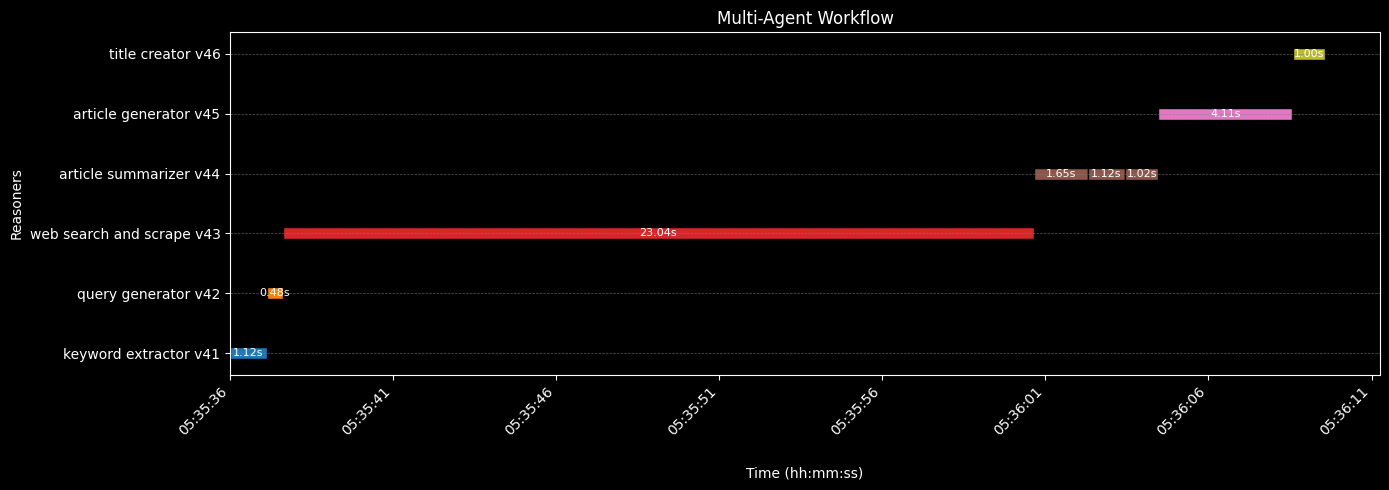

In [15]:
from brain.visualize import plot_workflow_matplotlib

session_id="4440d03c-69d2-4ebe-a8bf-bb64f0ce18ff"
lineage = brain_client.get_call_graph(session_id)
fig=plot_workflow_matplotlib(lineage['lineage'])
